<a href="https://colab.research.google.com/github/npgeorge/DS-Unit-2-Applied-Modeling/blob/master/NHL_Data_Project_Team_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NHL Data Project


#Answers

Choose your target. Which column in your tabular dataset will you predict?

I will predict on the "won" column for the Boston Bruins first, and apply that model to all teams.

Is your problem regression or classification?

Regression, win or loss is binary. I could try classification as well. 

How is your target distributed?

Regression: Is the target right-skewed? If so, you may want to log transform the target. TBD. 


Choose which observations you will use to train, validate, and test your model.

    - Are some observations outliers? Will you exclude them? TBD
    - Will you do a random split or a time-based split? Random. 


Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
- Begin to clean and explore your data.
- Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
file_path = '/content/gdrive/My Drive/Lambda School/NHL Project/game_teams_stats.csv'

In [0]:
df = pd.read_csv(file_path)

In [5]:
df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7
1,2011030221,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7
3,2011030222,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6
4,2011030223,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1


In [6]:
#bruins
#if a model works for one team, it *could* work broadly for others
#this may turn out to be a bad assumption
#this filter returns the df for the Bruins
#or statement for home and away games

bruins_id_condition = df['team_id'] == 6 #(df['home_team_id'] == 6) | (df['away_team_id'] == 6)
df_bruins = df[bruins_id_condition]
df_bruins.shape

(812, 15)

In [7]:
df_bruins.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
23,2010030311,6,home,False,REG,Claude Julien,2,33,26,30,4,0,38.8,10,4
25,2010030312,6,home,True,REG,Claude Julien,6,35,30,12,6,2,56.2,11,2
26,2010030313,6,away,True,REG,Claude Julien,2,25,19,8,3,0,56.9,7,6
28,2010030314,6,away,False,REG,Claude Julien,3,30,22,11,2,0,40.0,10,3
31,2010030315,6,home,True,REG,Claude Julien,3,20,25,10,4,0,57.7,9,2


In [28]:
#baseline, can we beat the Bruins baseline target?
baseline_target = 'won'
y_baseline = df_bruins[baseline_target]
y_baseline.value_counts(normalize=True) 

True     0.57266
False    0.42734
Name: won, dtype: float64

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
#train, test
train, test = train_test_split(df_bruins, 
                               train_size=0.80, 
                               test_size=0.20,
                               stratify=df_bruins['won'], 
                               random_state=42)
train.shape, test.shape

((649, 15), (163, 15))

In [30]:
#train, val
train, val = train_test_split(train, 
                              train_size=0.80, 
                              test_size=0.20, 
                              stratify=train['won'], 
                              random_state=42)
train.shape, val.shape

((519, 15), (130, 15))

In [0]:
'''
#making a wrangle feature function
def wrangle(X):

    # return the wrangled dataframe
    #return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
'''

In [0]:
#target and features
target = 'won'
#drop target 
train_features = train.drop(columns=[target, 'game_id','goals']) #dropped goals and model went to shit
#numeric features
num_feat = train_features.select_dtypes(include='number').columns.tolist()
#Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
#Get a list of all categorical features with cardinality <= 60
cat_feat = cardinality[cardinality <= 60].index.tolist()
# Combine the lists 
features = num_feat + cat_feat

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [55]:
#with XG Boost
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


pipeline_xgb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline_xgb.fit(X_train, y_train)
print('Training Accuracy', pipeline_xgb.score(X_train, y_train))
print('Validation Accuracy:', pipeline_xgb.score(X_val, y_val))

#predict on test
y_pred_xgb = pipeline_xgb.predict(X_test)

#Test Accuracy score
print('Test Accuracy for XG Boost', accuracy_score(y_test, y_pred_xgb))

Training Accuracy 0.8477842003853564
Validation Accuracy: 0.6153846153846154
Test Accuracy for XG Boost 0.50920245398773


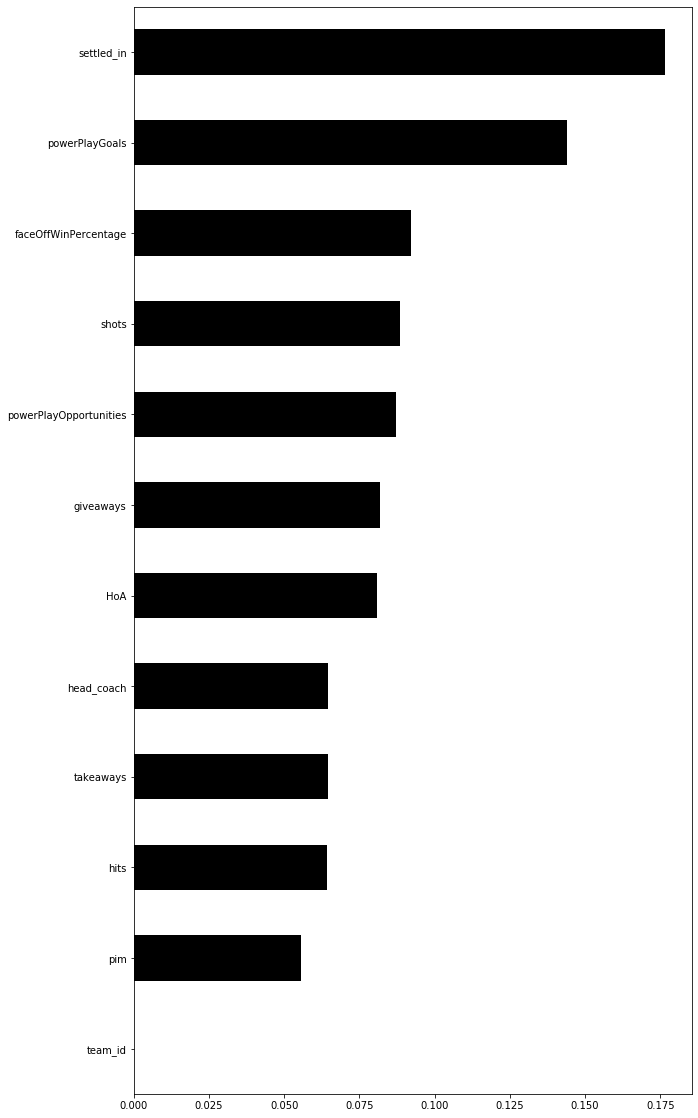

In [56]:
import matplotlib.pyplot as plt
model = pipeline_xgb.named_steps['xgbclassifier']
encoder = pipeline_xgb.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,20))
importances.sort_values().plot.barh(color='black');

In [57]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, 
                           n_jobs=-1, 
                           min_samples_leaf=1, 
                           max_depth=10, 
                           class_weight='balanced',
                           max_features=7, 
                           )
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on Train/Val
print('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))
print('Test Accuracy for Random Forest', accuracy_score(y_test, y_pred_rfc))

# Predict on Test Data
y_pred_rfc = pipeline.predict(X_test)

Training Accuracy 0.9922928709055877
Validation Accuracy 0.6153846153846154
Test Accuracy for Random Forest 0.5644171779141104


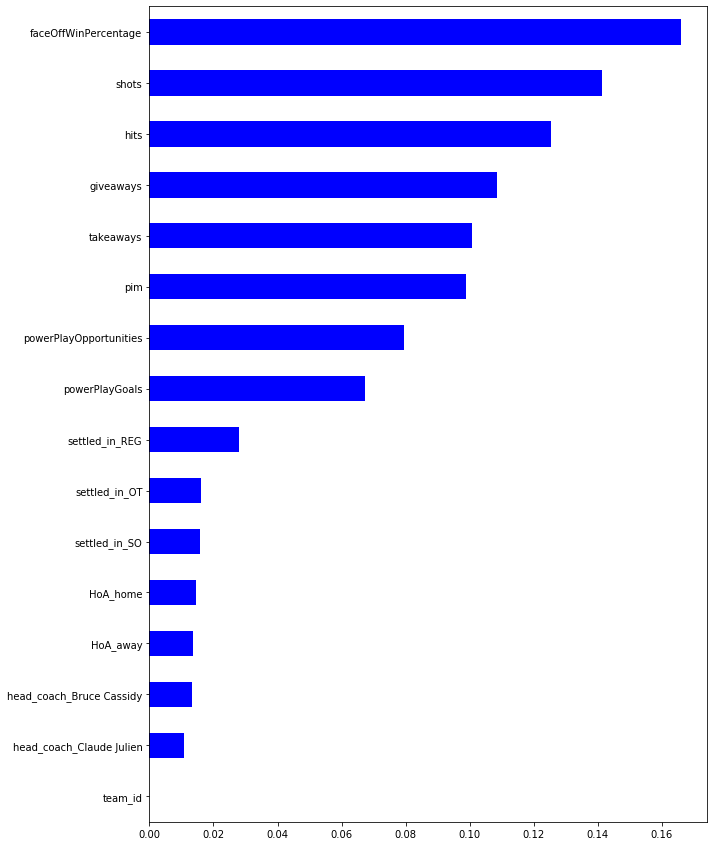

In [58]:
#feature importances
model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,15))
importances.sort_values().plot.barh(color='blue');

In [59]:
#permutation importance 
pipeline_pi = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = pipeline_pi.fit_transform(X_train)
X_val_transformed = pipeline_pi.transform(X_val)


model_pi = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_pi.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [61]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model_pi,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [62]:
permuter.feature_importances_

array([ 0.        ,  0.01692308,  0.03384615,  0.00461538, -0.03076923,
        0.04      ,  0.01846154,  0.02461538,  0.02769231,  0.02307692,
       -0.00307692, -0.00307692])

In [63]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.0400 ± 0.0265,powerPlayGoals
0.0338 ± 0.0209,hits
0.0277 ± 0.0317,takeaways
0.0246 ± 0.0406,giveaways
0.0231 ± 0.0138,HoA
0.0185 ± 0.0671,faceOffWinPercentage
0.0169 ± 0.0663,shots
0.0046 ± 0.0396,pim
0 ± 0.0000,team_id
-0.0031 ± 0.0345,settled_in


In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

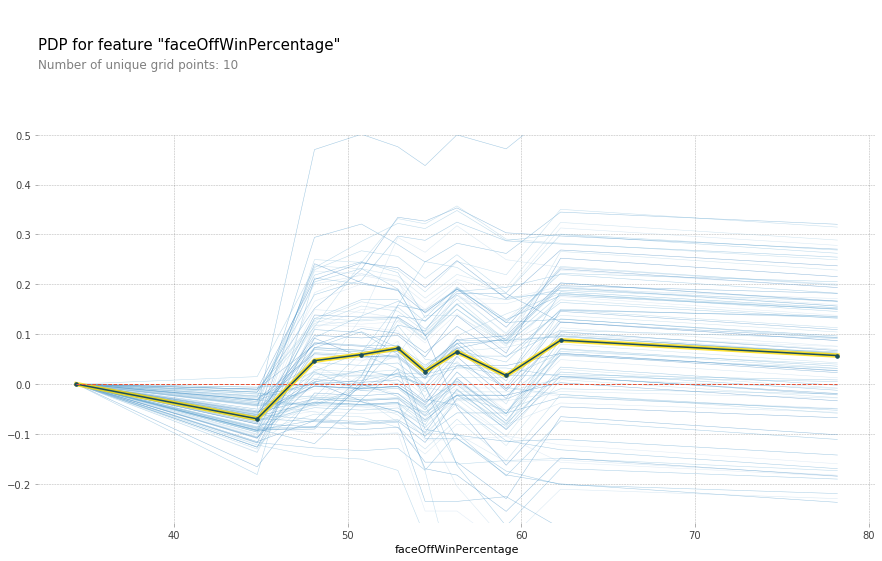

In [78]:
feature='faceOffWinPercentage'

pdp_faceoffs = pdp_isolate(
    model = pipeline_xgb,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

pdp_plot(pdp_faceoffs, feature_name=feature,  plot_lines=True, frac_to_plot=100);

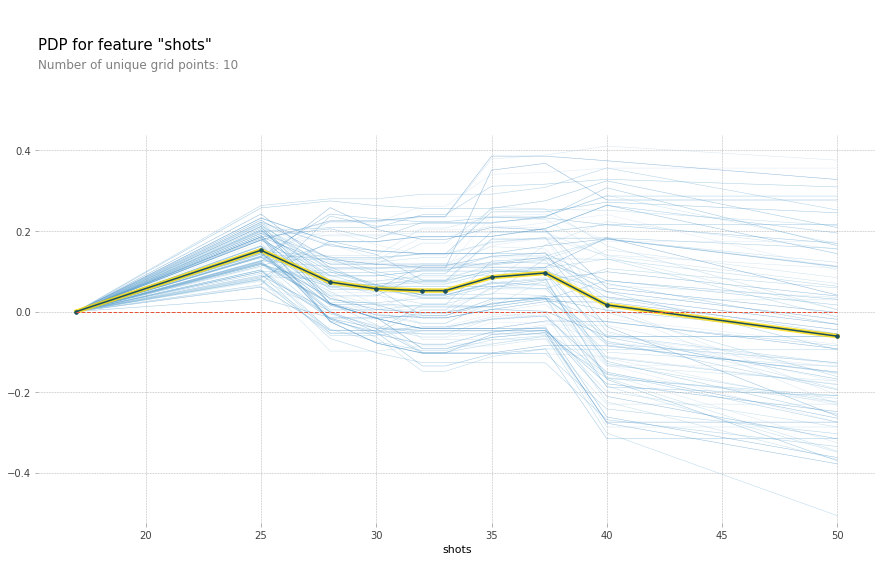

In [79]:
feature='shots'

pdp_shots = pdp_isolate(
    model = pipeline_xgb,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

pdp_plot(pdp_shots, feature_name=feature,  plot_lines=True, frac_to_plot=100);

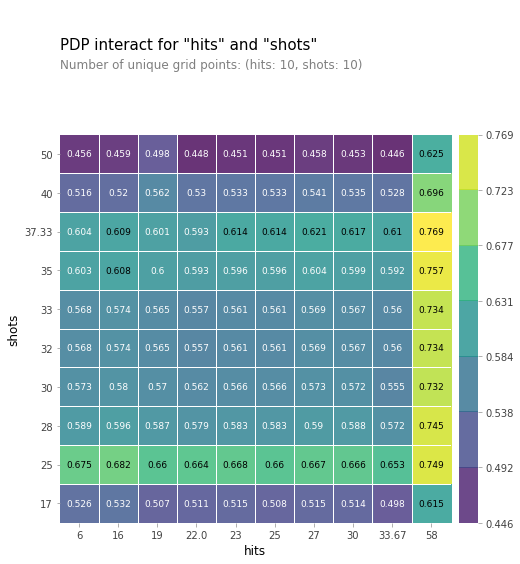

In [82]:
#PDP two features
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features=['hits','shots']

interaction = pdp_interact(
    model=pipeline_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);


In [0]:
#puck possesion feature?

#Make a SHAP Summary Plot

##These are awesome

In [72]:
#for ROC/AUC from class.. 
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.644356	validation_1-auc:0.528364
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.683623	validation_1-auc:0.538182
[2]	validation_0-auc:0.684935	validation_1-auc:0.525212
[3]	validation_0-auc:0.686444	validation_1-auc:0.539515
[4]	validation_0-auc:0.734515	validation_1-auc:0.583879
[5]	validation_0-auc:0.737465	validation_1-auc:0.579879
[6]	validation_0-auc:0.75345	validation_1-auc:0.598061
[7]	validation_0-auc:0.749454	validation_1-auc:0.582545
[8]	validation_0-auc:0.753238	validation_1-auc:0.578303
[9]	validation_0-auc:0.758342	validation_1-auc:0.594909
[10]	validation_0-auc:0.756127	validation_1-auc:0.593939
[11]	validation_0-auc:0.757068	validation_1-auc:0.598303
[12]	validation_0-auc:0.765993	validation_1-auc:0.60497
[13]	validation_0-auc:0.775973	validation_1-auc:0.607515
[14]	validation_0-auc:0.778142	validation_1-auc:0.608485


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [73]:
from sklearn.metrics import roc_auc_score
X_test_proc = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_proc)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba))

Test ROC AUC for class 1:
0.646236559139785


In [74]:
#ROC/AUC
from sklearn.metrics import roc_curve

# Probability for last class
y_pred_proba = pipeline_xgb.predict_proba(X_val)[:, -1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

#data frame
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.952505
1,0.000000,0.013333,0.952505
2,0.000000,0.106667,0.873611
3,0.036364,0.106667,0.853687
4,0.036364,0.266667,0.758967
5,0.109091,0.266667,0.743852
6,0.109091,0.280000,0.741844
7,0.127273,0.280000,0.738632
8,0.127273,0.293333,0.735936
9,0.145455,0.293333,0.733449


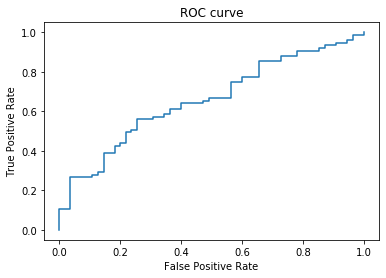

In [75]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [80]:
#shap #1
import shap
row = X_test.iloc[[100]]
explainer=shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit'             
)